In [1]:
!gdown --id 1ixh-tv-IKMdNjpoINbILJKGRNwcfH5Tj

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!unzip PageSegData

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
# from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Conv2DTranspose,Input,Add,UpSampling2D,Dropout,concatenate
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random
import seaborn as sns

In [ ]:
image_list=os.listdir('/content/drive/MyDrive/Computer Vision Dataset/PageSegData/PageImg/')
image_list=[filename.split(".")[0]for filename in image_list]
    
def get_segmented_img(img,n_classes):
    """
    Memasukkan gambar yang akan di segmen dan membuat label segmen yang cocok.
    """
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    cl_list=[0,24]

    seg_labels[:,:,0]=(img!=0).astype(int)
    return seg_labels

def preprocess_img(img):
    img=cv2.resize(img,(512,512))
    return img

def batch_generator(filelist,n_classes,batch_size):
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'/content/drive/MyDrive/Computer Vision Dataset/PageSegData/PageImg/{fn}.JPG',0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      img=cv2.resize(img,(512,512))
      img=np.expand_dims(img,axis=-1)
      #img = np.stack((img,)*3, axis=-1)
      img=img/255

      seg=cv2.imread(f'/content/drive/MyDrive/Computer Vision Dataset/PageSegData/PageSeg/{fn}_mask.png',1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)

FileNotFoundError: ignored

In [ ]:
image_list[0]

'1'

In [ ]:
img=cv2.imread('/content/drive/MyDrive/Computer Vision Dataset/PageSegData/PageImg/'+image_list[10]+'.JPG',1)
seg=cv2.imread('/content/drive/MyDrive/Computer Vision Dataset/PageSegData/PageSeg/'+image_list[10]+'_mask.png',1)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(seg,cmap='gray')
plt.title('Segmented Image')
plt.show()

In [ ]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs,conv10)
  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
  #model.summary()

  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  return model

#model = FCN(n_classes=2,  
            #  input_height=320, 
            #  input_width=320)
model=unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 512, 512, 12  0          ['conv2d_18[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  32832       ['up_sampling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 512, 512, 12  0           ['conv2d_1[0][0]',               
                                8)                                'conv2d_19[0][0]']              
                                                                                                  
 conv2d_20

In [ ]:
random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

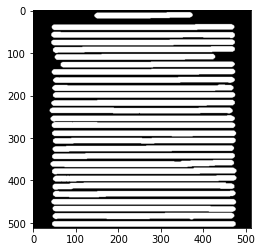

In [ ]:
img,seg=next(batch_generator(file_train,2,1))
plt.imshow(np.squeeze(seg[:,:,:,0],axis=0),cmap='gray')

In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only=True, period=1)
model.fit(batch_generator(file_train,2,2),epochs=10,steps_per_epoch=100,validation_data=batch_generator(file_test,2,2),validation_steps=200,callbacks=[mc],shuffle=1)

Epoch 1/10
10/10 [==============================] - 1190s 125s/step - loss: 0.6893 - accuracy: 0.5685 - val_loss: 0.6920 - val_accuracy: 0.6521
Epoch 2/10
10/10 [==============================] - 1156s 122s/step - loss: 0.6917 - accuracy: 0.6093 - val_loss: 0.6921 - val_accuracy: 0.5760
Epoch 3/10
10/10 [==============================] - 1150s 122s/step - loss: 0.6911 - accuracy: 0.6210 - val_loss: 0.6914 - val_accuracy: 0.6353
Epoch 4/10
 1/10 [==>...........................] - ETA: 8:32 - loss: 0.6907 - accuracy: 0.5803

In [ ]:
img=cv2.imread(f'/content/drive/MyDrive/Computer Vision Dataset/PageSegData/PageImg/2.JPG',0)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
img= np.expand_dims(img,axis=-1)

1/1 [==============================] - 0s 20ms/step


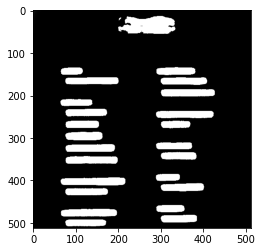

In [ ]:
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

In [ ]:
# copy = img.copy()
# plt.imshow(copy, cmap="gray")

In [ ]:
plt.imsave('test_img_mask.JPG',pred)

In [ ]:
coordinates=[]

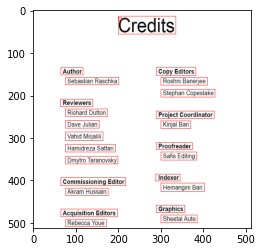

In [ ]:
import cv2
img = cv2.imread('/content/test_img_mask.JPG',0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread('/content/drive/MyDrive/Computer Vision Dataset/PageSegData/PageImg/2.JPG')
ori_img=cv2.resize(ori_img,(512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # Mencari bordir kotak
    x, y, w, h = cv2.boundingRect(c)
    # Bordir kotak divisualisasikan dengan warna merah
    cv2.rectangle(ori_img, (x, y), (x+w,y+h), 255, 1)
    coordinates.append([x,y,(x+w),(y+h)])

#cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

plt.imshow(ori_img)